# Insect Classifier
First personal fast ai project by @sasha

### Goal
Create a simple web app where a user may upload the picture of an insect found in their house and it is classified into one of the top 5 most common household insects found in the Netherlands

### This file:
This file provides the data gathering aspect of the model, and the subsequent creation and training of the model

#### Imports

In [1]:
from fastbook import *
from fastai.vision.widgets import *
import os

### Data gathering
Data will be gathered using the Bing image search api, and stored in the folder "insects" with each category of insects having it's own folder with the name of insect as the title
#### API Key

In [8]:
key = "" # fill in your own key here and delete next line
from private import key # my own API Key

#### Load insect types

In [14]:
insect_types = ["silverfish", "cockroach", "fruit fly", "bed bug", "mosquito"]
path = Path("insects")

In [16]:
if not path.exists(): path.mkdir() # create directory for storing all images

In [31]:
for insect in insect_types:
    insect_dir = Path(path/insect) # specify path per insect
    if not insect_dir.exists(): 
        insect_dir.mkdir() # create a dir per insect
        # get urls of 150 insect images
        img_urls = search_images_bing(key, f"{insect} insect").attrgot("contentUrl") 
        download_images(insect_dir, urls = img_urls) # download images from all urls and save to dir

#### Clean images

In [144]:
images = get_image_files(path) # get all images
corrupt_images = verify_images(images) # idenitfy corrupt images
corrupt_images.map(Path.unlink) # delete corrupt images

(#0) []

#### Setup data loader objects and load it with the images

In [206]:
insects = DataBlock(
    blocks = (ImageBlock, CategoryBlock), # create tuple of image and category
    get_items = get_image_files, # specify that items are the image files
    splitter = RandomSplitter(valid_pct = 0.2, seed = 69), # save 20% of data for validation, use a constant seed as to avoid effects of randomness when rerunning the model
    get_y = parent_label, # specify that category labels are parent dir
    item_tfms = RandomResizedCrop(224, min_scale = 0.5), # make each image 224x224 with maximimum crop of 50%
    batch_tfms = aug_transforms() # add more data using data augmentation
)
dls = insects.dataloaders(path)

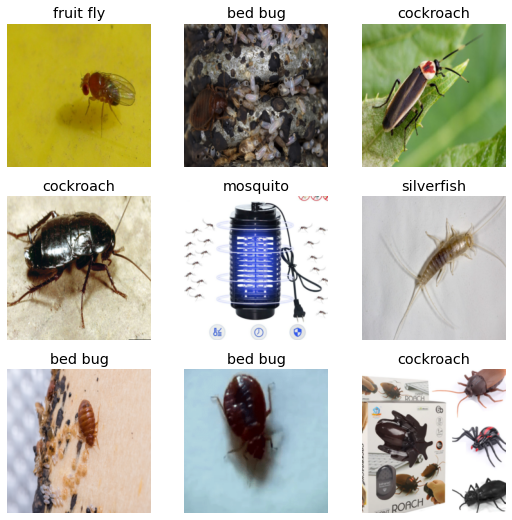

In [207]:
dls.valid.show_batch()

#### Create and train model

In [208]:
model = cnn_learner(dls, resnet50, metrics = accuracy) # create model based on the resnet 18 model architecture
# as resnet18 is a pretrained image recognition model we apply transfer learning to save time and compute
model.fine_tune(11) # train for 4 epochs then manually sort highest loss images then train more

epoch,train_loss,valid_loss,accuracy,time
0,2.154546,0.593502,0.792208,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.545942,0.337979,0.870130,00:11
1,0.424730,0.268670,0.909091,00:11
2,0.334300,0.242976,0.935065,00:11
3,0.271061,0.246028,0.935065,00:10
4,0.237462,0.276744,0.948052,00:11
5,0.198677,0.331994,0.948052,00:11
6,0.176440,0.299841,0.948052,00:10
7,0.150922,0.303307,0.922078,00:10
8,0.134591,0.303416,0.935065,00:11
9,0.118175,0.237172,0.935065,00:11


#### Manually correct poor pictures in the model

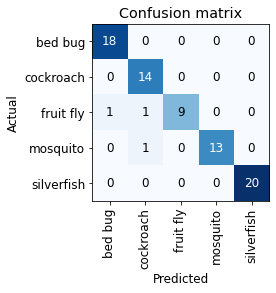

In [209]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix()

As we can see from the confusion matrix and accuracy the model is not quite ideal, lets review the images with the highest losses and manually delete poor examples

In [210]:
cleaner = ImageClassifierCleaner(model, width = 20000, max_n = 150)
cleaner

In [200]:
cleaner.delete()

(#1) [11]

In [201]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink() 

The files were cleaned by removing images which did not match the insect and the training of the model was repeated

#### Save model file

In [211]:
model.export()